In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

In [2]:
torch.__version__,torchvision.__version__

('2.1.2', '0.16.2')

In [3]:
try:
    from torchinfo import summary
except:
    print("module not founf")
    !pip install torchinfo
    from torchinfo import summary

In [4]:
# import shutil

# directory_path = "/kaggle/working/going_modular"

# try:
#     shutil.rmtree(directory_path)
#     print(f'Directory {directory_path} and its contents deleted.')
# except OSError as e:
#     print(f'Error: {e.strerror}')

In [5]:
 try:
        
        print("module already exists importing...")
        from going_modular import data_setup,engine
except:
        print(f"dawnloading the module")
        !git clone "https://github.com/nebyu08/torch.git"
        !mv torch/going_modular .
        !rm -rf torch
        from going_modular import data_setup,engine

module already exists importing...
dawnloading the module
Cloning into 'torch'...
remote: Enumerating objects: 557, done.
remote: Counting objects: 100% (392/392), done.
remote: Compressing objects: 100% (367/367), done.
remote: Total 557 (delta 31), reused 381 (delta 20), pack-reused 165
Receiving objects: 100% (557/557), 82.33 MiB | 43.96 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
def set_seed(seed:int=42):
    """ torch set seed."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [8]:
#lets write a function that downloads data
import requests
from pathlib import Path
import zipfile
import os

def download_data(source:str,
                 destination:str,
                 remove_source:bool=True)->Path:
    data_path=Path("data/")
    image_path=data_path/destination

    if data_path.is_dir():
        print(f"the path already exists")
    else:
        data_path.mkdir(
            parents=True,exist_ok=True
        )
    
    #get the name of the detination file
    target_file=Path(source).name
    
    #lets download the data
    with open(data_path/target_file,"wb") as f:
        request=requests.get(source)
        print("downloading data...")
        f.write(request.content)
        
    #unzip the files
    with zipfile.ZipFile(data_path/target_file,"r") as zip_ref:
        print("unzipping the data")
        zip_ref.extractall(image_path)
    if remove_source:
        os.remove(data_path/target_file)
    return image_path


source_link="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

In [9]:
image_path=download_data(source=source_link,
             destination="pizza_steak_sushi")

downloading data...
unzipping the data


In [10]:
train_dir=image_path/"train"
test_dir=image_path/"test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# preparing data loader and transforms

## data loader with manual transforms

In [11]:
from torchvision import transforms

normalize=transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

manual_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

In [12]:
#load using the our own module
from going_modular import data_setup
batch_size=32

train_dataloader,test_dataloader,class_names=data_setup.create_dataloader(train_dir=train_dir,
                                                                         test_dir=test_dir,
                                                                         transform=manual_transform,
                                                                         batch_size=batch_size)

In [13]:
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bf86697dcf0>,
 ['pizza', 'steak', 'sushi'])

## data transform with automatic way

In [14]:
from torchvision import models

weights=models.EfficientNet_B0_Weights.DEFAULT

#automatic transforms
automatic_transforms=weights.transforms()

In [15]:
weights,automatic_transforms

(EfficientNet_B0_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [16]:
automatic_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [17]:
#train and test data loader
train_dataloader,test_dataloader,class_names=data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=batch_size
)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bf86697d4e0>,
 ['pizza', 'steak', 'sushi'])

In [18]:
print(automatic_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


# loading a pre-trained model

In [19]:
#lets load the weights and the model
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s] 


In [20]:
for param in model.features.parameters():
    param.requires_grad=False

In [21]:
model.classifier
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names))
).to(device)

In [22]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter()
writer

2024-02-19 07:55:15.700600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 07:55:15.700710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 07:55:15.856338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
summary(model,
       input_size=(32,3,224,224),
        verbose=0,
        col_width=20,
       col_names=["input_size","output_size","num_params","trainable"])

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]   [32, 16, 112, 112]   --                   Fal

In [24]:
from going_modular.engine import train_step,test_step
from typing import List,Tuple,Dict
from tqdm.auto import tqdm

def train_model(model:nn.Module,
               train_data:torch.utils.data.DataLoader,
               test_data:torch.utils.data.DataLoader,
               loss_fn:torch.nn,
                optimizer:torch.optim.Optimizer,
                epochs:int=5,
               device:torch.device="cpu"):
    """this is an update verison of train_model from the local package engine in that it contains the 
    summary writer from tensorboard to display its training and testing, accuracy and loss 
    """
    
    #TRAIN MDOEL
    results={"train_loss":[],
            "train_acc":[],
            "test_loss":[],
            "test_acc":[]}
    
    train_loss,train_acc=0,0
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model=model,
                                       train_data=train_data,
                                       loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device
                                       )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        
        #TEST THE MDODEL
        test_loss,test_acc=0,0
        test_loss,test_acc=test_step(model=model,
                             test_data=test_data,
                            loss_fn=loss_fn,
                            device=device
                            )
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        #lets display the process
        print(f"the train loss| {train_loss} | test loss {test_loss} and train acc {train_acc} ,test acc {test_acc} ")
        
        #lets add to the summary write the results of the model
        #loss...
        writer.add_scalars(main_tag="loss",
                          tag_scalar_dict={
                              "train_loss":train_loss,
                              "test_loss":test_loss
                          },
                          global_step=epoch)
        #accuracy
        writer.add_scalars(main_tag="accuracy",
                          tag_scalar_dict={
                              "train_acc":train_acc,
                              "test_acc":test_acc
                          },
                          global_step=epoch)
        #lets show a graph
        writer.add_graph(
            model=model,
            input_to_model=torch.randn((32,3,224,224)).to(device),
            
        )
        
    writer.close()
        
        
    return results

# train the mdoel using the updated train funtion

In [25]:
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

## display using tensorboard

In [26]:
set_seed()
result=train_model(
    model=model,
    train_data=train_dataloader,
    test_data=test_dataloader,
    loss_fn=loss,
    optimizer=optimizer,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

the train loss| 1.1040527075529099 | test loss 0.9049880703290304 and train acc 1.609375 ,test acc 0.7777777777777778 
the train loss| 0.8715098351240158 | test loss 0.7820528149604797 and train acc 2.796875 ,test acc 1.0 
the train loss| 0.773675948381424 | test loss 0.6813303033510844 and train acc 3.046875 ,test acc 1.1111111111111112 
the train loss| 0.6756883636116982 | test loss 0.6815216143925985 and train acc 3.109375 ,test acc 1.0 
the train loss| 0.6754202470183372 | test loss 0.7043867309888204 and train acc 2.984375 ,test acc 0.7777777777777778 


In [27]:
print(result)

{'train_loss': [1.1040527075529099, 0.8715098351240158, 0.773675948381424, 0.6756883636116982, 0.6754202470183372], 'train_acc': [1.609375, 2.796875, 3.046875, 3.109375, 2.984375], 'test_loss': [0.9049880703290304, 0.7820528149604797, 0.6813303033510844, 0.6815216143925985, 0.7043867309888204], 'test_acc': [0.7777777777777778, 1.0, 1.1111111111111112, 1.0, 0.7777777777777778]}


# view the tesnor board 

In [28]:
%reload_ext tensorboard
%tensorboard --logdir=runs --port=6007

# save the model output into different directories    
* and then we visualize and compare between models
* saving the results into different directories.... one experiment = one folder
* we save the models
  names,experiment data/time,experiment name,Extra


In [29]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name:str,
                  model_name:str,
                  extra:str=None
                 ):
    import os
    from datetime import datetime
    
    timestamp=datetime.now().strftime("%y-%m-%d")
    if extra:
        log_dir=os.path.join("runs",timestamp,experiment_name,model_name,extra)
    else:
        log_dir=os.path.join("runs",timestamp,experiment_name,model_name)
    
    return SummaryWriter(log_dir)

In [30]:
example_writer=create_writer(
    experiment_name="10%_train",
    model_name="efficient_net0",
    extra="10_epochs"
)
example_writer

# update the train function so that it can have the "summary writer

In [31]:
from going_modular.engine import train_step,test_step
from typing import List,Tuple,Dict
from tqdm.auto import tqdm

def train_model(model:nn.Module,
               train_data:torch.utils.data.DataLoader,
               test_data:torch.utils.data.DataLoader,
               loss_fn:torch.nn,
                optimizer:torch.optim.Optimizer,
                writer:torch.utils.tensorboard,
                 epochs:int=5,
               device:torch.device="cpu"):
    """this is an update verison of train_model from the local package engine in that it contains the 
    summary writer from tensorboard to display its training and testing, accuracy and loss 
    """
    
    #TRAIN MDOEL
    results={"train_loss":[],
            "train_acc":[],
            "test_loss":[],
            "test_acc":[]}
    
    train_loss,train_acc=0,0
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model=model,
                                       train_data=train_data,
                                       loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device
                                       )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        
        #TEST THE MDODEL
        test_loss,test_acc=0,0
        test_loss,test_acc=test_step(model=model,
                             test_data=test_data,
                            loss_fn=loss_fn,
                            device=device
                            )
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        #lets display the process
        print(f"the train loss| {train_loss} | test loss {test_loss} and train acc {train_acc} ,test acc {test_acc} ")
        
        #lets add to the summary write the results of the model
        #loss...
        if writer:
            writer.add_scalars(main_tag="loss",
                              tag_scalar_dict={
                                  "train_loss":train_loss,
                                  "test_loss":test_loss
                              },
                              global_step=epoch)
            #accuracy
            writer.add_scalars(main_tag="accuracy",
                              tag_scalar_dict={
                                  "train_acc":train_acc,
                                  "test_acc":test_acc
                              },
                              global_step=epoch)
            #lets show a graph
            writer.add_graph(
                model=model,
                input_to_model=torch.randn((32,3,224,224)).to(device),
                
            )
        else:
            pass
        
    writer.close()
        
        
    return results

# setup 2 experiments:
compare between 2 models and the variation between them is 

* **number of epochs**: between 10 epochs and 20 epochs
* **model size**: efficient netB0 and efficientnetB2
* **change the amount of data**: 10% vs 20% of pizza-steak-sushi

# downlaod the 2 datasets

In [32]:
data_10_percent=download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)
data_20_percent=download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent"
)

the path already exists
downloading data...
unzipping the data
the path already exists
downloading data...
unzipping the data


# turn the data into datasets and dataloader

In [33]:
train_10_percent=data_10_percent/"train"
train_20_percent=data_20_percent/"train"

test_dir=data_10_percent/"test"

In [34]:
# lets make transform function four our dataloader
from torchvision.transforms import Normalize
from torchvision import transforms

normalize=Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

simple_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

In [35]:
#use our local package to use D.S and D.L
from going_modular.data_setup import create_dataloader
batch_size=32

#using 10% data 
train_data_10p_loader,test_dataloader,class_names=create_dataloader(
    train_dir=train_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=batch_size
)

#using 20% data
train_data_20p_loader,test_dataloader,class_names=create_dataloader(
    train_dir=train_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=batch_size,
)

In [36]:
train_data_10p_loader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bf834b095a0>,
 ['pizza', 'steak', 'sushi'])

In [37]:
train_data_20p_loader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bf834b0a9e0>,
 ['pizza', 'steak', 'sushi'])

# making function that make models

In [38]:
#make a model make
import torchvision
import torch.nn as nn

def makeb0_model():
    """this makes the """
    set_seed()
    weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model_b0=torchvision.models.efficientnet_b0(weights=weights)
    
    #freezing the lower layer of the model
    for param in model_b0.features.parameters():
        param.requires_grad=False

    #assigning the last layer to the number of labels
    model_b0.classifier=nn.Sequential(
        nn.Dropout(p=0.2,inplace=True),
        nn.Linear(in_features=1280,out_features=len(class_names),bias=True)
    ).to(device)
    model_b0.name="efficientb0"

    print(f"created the model {model_b0.name}")
    return model_b0
    
def makeb2_model():
    weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model_b2=torchvision.models.efficientnet_b2(weights=weights)
    #freeze the lower layer
    for param in model_b2.features.parameters():
        param.requires_grad=False
    
    model_b2.classifier=nn.Sequential(
        nn.Dropout(p=0.3,inplace=True),
        nn.Linear(in_features=1408,out_features=len(class_names),bias=True)
    ).to(device)

    model_b2.name="efficientb2"   
    print(f"created the model {model_b2.name}")
   
    
    return model_b2

In [39]:
created_modelb0=makeb0_model()
created_modelb2=makeb2_model()

created the model efficientb0


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 128MB/s] 


created the model efficientb2


In [40]:
 summary(model=created_modelb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# create experiment tracking 

In [41]:
%%time
from going_modular.utils import save_model

num_epochs=[5,10]

models=["efficientb0","efficientb2"]

#create a dataloader dictionary
dataloader_dict={
    "data_10_percent":train_data_10p_loader,
    "data_20_percent":train_data_20p_loader
}

for data_name,data_loader in dataloader_dict.items():
    
    for epochs in num_epochs:
        
        for model_name in models:
           
            print(f"[INFO] data name: {data_name}")
            print(F"[INFO] number of epochs: {epochs}")
            print(f"[INFO] model name:{model_name}")
            
            if model_name=="efficientb0":
                model=makeb0_model()
                model.to(device)
            else:
                model=makeb2_model()
                model.to(device)
                
            loss_fn=nn.CrossEntropyLoss()
            optimizer=torch.optim.Adam(params=model.parameters(),lr=0.01)
            train_model(
                model=model,
                train_data=data_loader,
                test_data=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                writer=create_writer(experiment_name=data_name,
                                model_name=model_name,
                                extra=f"{epochs}_epochs"),
                epochs=epochs,
                device=device
            )
            
            #save the model
            save_filepath=f"{model_name}_{data_name}_{epochs}_epochs.pth"
            save_model(
                model=model,
                target="models",
                model_name=save_filepath
            )
            

[INFO] data name: data_10_percent
[INFO] number of epochs: 5
[INFO] model name:efficientb0
created the model efficientb0


  0%|          | 0/5 [00:00<?, ?it/s]

the train loss| 0.7600952610373497 | test loss 0.29501208166281384 and train acc 2.3125 ,test acc 1.1111111111111112 
the train loss| 0.3864186592400074 | test loss 0.4966105471054713 and train acc 2.96875 ,test acc 0.8888888888888888 
the train loss| 0.3543700557202101 | test loss 0.31356821954250336 and train acc 2.953125 ,test acc 1.1111111111111112 
the train loss| 0.2466366495937109 | test loss 0.264973908662796 and train acc 3.375 ,test acc 1.1111111111111112 
the train loss| 0.6456206100992858 | test loss 0.289556086063385 and train acc 3.203125 ,test acc 1.1111111111111112 
saving the model into models/efficientb0_data_10_percent_5_epochs.pth
[INFO] data name: data_10_percent
[INFO] number of epochs: 5
[INFO] model name:efficientb2
created the model efficientb2


  0%|          | 0/5 [00:00<?, ?it/s]

the train loss| 0.9825312420725822 | test loss 0.7302656670411428 and train acc 2.109375 ,test acc 0.4444444444444444 
the train loss| 0.8329602628946304 | test loss 0.3694663842519124 and train acc 2.515625 ,test acc 1.0 
the train loss| 0.5458306921645999 | test loss 0.32375718156496686 and train acc 2.796875 ,test acc 1.1111111111111112 
the train loss| 0.4384780302643776 | test loss 0.5689339935779572 and train acc 3.125 ,test acc 0.7777777777777778 
the train loss| 0.30418948736041784 | test loss 0.5923497428496679 and train acc 3.234375 ,test acc 0.7777777777777778 
saving the model into models/efficientb2_data_10_percent_5_epochs.pth
[INFO] data name: data_10_percent
[INFO] number of epochs: 10
[INFO] model name:efficientb0
created the model efficientb0


  0%|          | 0/10 [00:00<?, ?it/s]

the train loss| 0.7600952610373497 | test loss 0.29501208166281384 and train acc 2.3125 ,test acc 1.1111111111111112 
the train loss| 0.3864186592400074 | test loss 0.4966105471054713 and train acc 2.96875 ,test acc 0.8888888888888888 
the train loss| 0.3543700557202101 | test loss 0.31356821954250336 and train acc 2.953125 ,test acc 1.1111111111111112 
the train loss| 0.2466366495937109 | test loss 0.264973908662796 and train acc 3.375 ,test acc 1.1111111111111112 
the train loss| 0.6456206100992858 | test loss 0.289556086063385 and train acc 3.203125 ,test acc 1.1111111111111112 
the train loss| 0.20308814058080316 | test loss 0.8933917184670767 and train acc 3.203125 ,test acc 0.5555555555555556 
the train loss| 0.2992873229086399 | test loss 0.31882640222708386 and train acc 3.21875 ,test acc 1.1111111111111112 
the train loss| 0.49519840255379677 | test loss 0.30352920293807983 and train acc 3.359375 ,test acc 1.1111111111111112 
the train loss| 0.28926412749569863 | test loss 0.3

  0%|          | 0/10 [00:00<?, ?it/s]

the train loss| 0.7267952412366867 | test loss 0.82246067126592 and train acc 2.390625 ,test acc 0.3333333333333333 
the train loss| 0.40928452648222446 | test loss 0.2823461989561717 and train acc 3.046875 ,test acc 1.1111111111111112 
the train loss| 0.5211033783853054 | test loss 0.36623940865198773 and train acc 2.859375 ,test acc 1.1111111111111112 
the train loss| 0.35675103683024645 | test loss 0.39908846219380695 and train acc 3.3125 ,test acc 1.0 
the train loss| 0.45238553127273917 | test loss 0.32224077979723614 and train acc 3.234375 ,test acc 1.1111111111111112 
the train loss| 0.1617000256665051 | test loss 0.4670649568239848 and train acc 3.3125 ,test acc 1.0 
the train loss| 0.4194692266173661 | test loss 0.3266136695941289 and train acc 3.21875 ,test acc 1.1111111111111112 
the train loss| 0.7379013719037175 | test loss 0.29196323454380035 and train acc 3.25 ,test acc 1.1111111111111112 
the train loss| 0.304736799094826 | test loss 0.6142760415871938 and train acc 3.4

  0%|          | 0/5 [00:00<?, ?it/s]

the train loss| 0.6029447828729947 | test loss 0.21672877172629038 and train acc 1.4755555555555557 ,test acc 1.1111111111111112 
the train loss| 0.30327820479869844 | test loss 0.24700174232323965 and train acc 1.7866666666666666 ,test acc 1.1111111111111112 
the train loss| 0.2624698732048273 | test loss 0.31837797661622363 and train acc 1.8266666666666667 ,test acc 1.0 
the train loss| 0.2222718007862568 | test loss 0.23699437081813812 and train acc 1.8266666666666669 ,test acc 1.1111111111111112 
the train loss| 0.16635744174321493 | test loss 0.2905435413122177 and train acc 1.8755555555555554 ,test acc 1.1111111111111112 
saving the model into models/efficientb0_data_20_percent_5_epochs.pth
[INFO] data name: data_20_percent
[INFO] number of epochs: 5
[INFO] model name:efficientb2
created the model efficientb2


  0%|          | 0/5 [00:00<?, ?it/s]

the train loss| 0.6526331722736358 | test loss 0.3813401758670807 and train acc 1.4133333333333336 ,test acc 1.0 
the train loss| 0.39921012620131174 | test loss 0.3546507904926936 and train acc 1.7333333333333336 ,test acc 1.0 
the train loss| 0.29590214348087707 | test loss 0.5462449590365092 and train acc 1.728888888888889 ,test acc 0.8888888888888888 
the train loss| 0.33616794149080914 | test loss 0.4489722599585851 and train acc 1.831111111111111 ,test acc 0.8888888888888888 
the train loss| 0.23140085190534593 | test loss 0.3847348938385646 and train acc 1.8355555555555556 ,test acc 1.0 
saving the model into models/efficientb2_data_20_percent_5_epochs.pth
[INFO] data name: data_20_percent
[INFO] number of epochs: 10
[INFO] model name:efficientb0
created the model efficientb0


  0%|          | 0/10 [00:00<?, ?it/s]

the train loss| 0.6029447828729947 | test loss 0.21672877172629038 and train acc 1.4755555555555557 ,test acc 1.1111111111111112 
the train loss| 0.30327820479869844 | test loss 0.24700174232323965 and train acc 1.7866666666666666 ,test acc 1.1111111111111112 
the train loss| 0.2624698732048273 | test loss 0.31837797661622363 and train acc 1.8266666666666667 ,test acc 1.0 
the train loss| 0.2222718007862568 | test loss 0.23699437081813812 and train acc 1.8266666666666669 ,test acc 1.1111111111111112 
the train loss| 0.16635744174321493 | test loss 0.2905435413122177 and train acc 1.8755555555555554 ,test acc 1.1111111111111112 
the train loss| 0.29529406179984413 | test loss 0.24345941096544266 and train acc 1.8844444444444444 ,test acc 1.1111111111111112 
the train loss| 0.22704621478915216 | test loss 0.23481514801581702 and train acc 1.8533333333333333 ,test acc 1.1111111111111112 
the train loss| 0.19216707622011503 | test loss 0.24584141870339712 and train acc 1.8533333333333333 ,

  0%|          | 0/10 [00:00<?, ?it/s]

the train loss| 0.7229574799537659 | test loss 0.564096987247467 and train acc 1.297777777777778 ,test acc 0.7777777777777778 
the train loss| 0.38459170758724215 | test loss 0.3627055883407593 and train acc 1.7333333333333334 ,test acc 1.0 
the train loss| 0.32281081279118856 | test loss 0.3027975062529246 and train acc 1.7822222222222224 ,test acc 1.1111111111111112 
the train loss| 0.310342538356781 | test loss 0.4195963442325592 and train acc 1.7644444444444445 ,test acc 1.0 
the train loss| 0.4045819739500682 | test loss 0.4240157753229141 and train acc 1.7511111111111113 ,test acc 1.0 
the train loss| 0.33482910295327506 | test loss 0.32470761239528656 and train acc 1.7511111111111113 ,test acc 1.1111111111111112 
the train loss| 0.24257390225927036 | test loss 0.4794427255789439 and train acc 1.8488888888888888 ,test acc 0.8888888888888888 
the train loss| 0.4069253613551458 | test loss 0.3808087607224782 and train acc 1.8444444444444446 ,test acc 1.0 
the train loss| 0.38110128

# lets see what the results are in tensorboard

In [42]:
!kill 209

/bin/bash: line 0: kill: (209) - No such process


In [43]:
%reload_ext tensorboard
%tensorboard --logdir=runs --port=6008

# **load the best model out in our training loop**

In [44]:
#save the model path
best_model_path="models/efficientb2_data_20_percent_10_epochs.pth"
#creating the architecture of the models
best_model=makeb2_model()
#loading the weight into the model
best_model.load_state_dict(torch.load(best_model_path))

created the model efficientb2


<All keys matched successfully>

In [45]:
#check the size of the model
from pathlib import Path
#turns byte into megebayte
effnet_b2_model_size=Path(best_model_path).stat().st_size //(1024*1024)
print(f"the best efficientnet size is {effnet_b2_model_size}MB")

the best efficientnet size is 29MB


# lets make prediction on custom dataset

In [46]:
data_20_percent/"test"

PosixPath('data/pizza_steak_sushi_20_percent/test')

In [47]:
class_names

['pizza', 'steak', 'sushi']

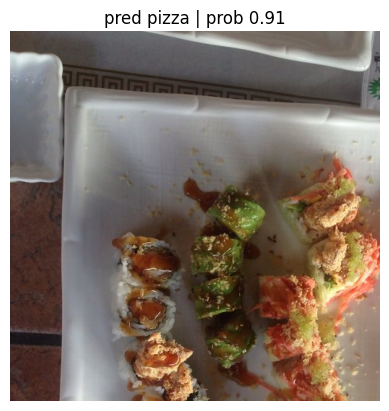

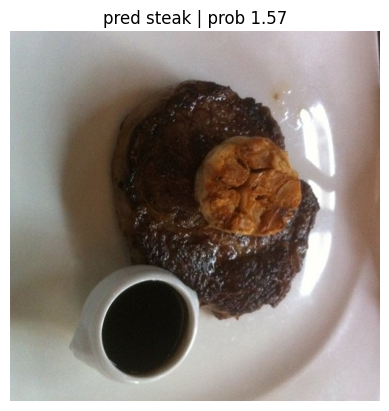

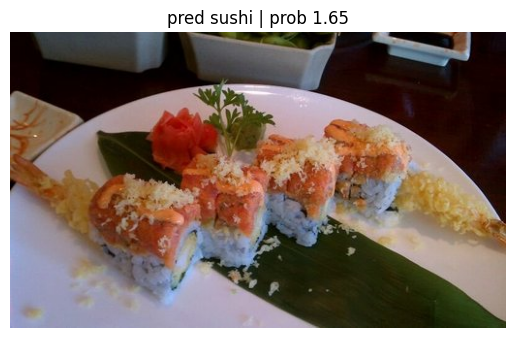

In [51]:
import random
from going_modular.prediction import custom_predictions

num_images=3
test_image_list=list(Path(data_20_percent/"test").glob("*/*.jpg"))
test_image_sample=random.sample(
    population=test_image_list,
    k=num_images
)

for image_path in test_image_sample:
    custom_predictions(
        model=best_model,
        img_dir=image_path,
        class_names=class_names,
        img_size=(224,224),        
    )